# <font color='orange'>Catégorisez automatiquement des questions</font>

##  <font color='navy'>Sommaire

**Partie 1 : Construction du Bag-of-words**
- <a href="#C1">Récupération des données</a>
- <a href="#C5">Nettoyage des données texte</a>
- <a href="#C10">Vectorisation du texte</a>
- <a href="#C15">Exploration des données</a>

# <font color='navy'>PARTIE 1 - Construction du Bag-of-words</font>

**Quelques définitions pour introduire l'analyse de données texte.**

- Le corpus : un ensemble de documents (des textes dans notre cas), regroupés dans une optique ou dans une thématique précise. 

- Un document : la notion de document fait référence à un texte appartenant au corpus, mais indépendant des autres textes. Il peut être constitué d'une ou plusieurs phrases, un ou plusieurs paragraphes.

- Un token : le terme token désigne généralement un mot et/ou un élément de ponctuation. La phrase "Hello World!" comprend donc 3 tokens. 

- Le vocabulaire : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus.

#### <font color='orange'>**Import des librairies python.**</font>

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import swifter
import re
import string
import random
import contractions
from collections import Counter
import pickle
from scipy import sparse

# Détection du langage.
import langdetect 
from langdetect import detect

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE

# Fonctions.
import importlib

import data_preprocessing_config
importlib.reload(data_preprocessing_config)
from data_preprocessing_config import (
    language_names, 
    seuil_representation_top_langage, 
    seuil_min_rare_word
)

import data_preprocessing_fonction
importlib.reload(data_preprocessing_fonction)
from data_preprocessing_fonction import (
    detect_language_and_analyze,
    filter_top_language,
    clean_tags,
    count_words,
    get_word_frequencies,
    remove_special_characters,
    convert_lists_to_text,
    pos_tagging_fct,
    ner_fct,
    transform_bow_lem_fct,
    transform_bow_fct,
    transform_dl_fct,
    display_token_info,
    remove_html_tags_edges,
    filter_by_pos_tags
)

# preprocessing text.
# nltk.
import nltk
from nltk.tokenize import RegexpTokenizer, wordpunct_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

############## TEST
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')


# spacy.
import spacy
nlp = spacy.load('en_core_web_md')

# Analyse exploratoire.
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jouvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jouvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## <a name="C1"><font color='navy'>Récupération des données</font></a>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C2">Execution de la requête.</a>
- <a href="#C3">Scraping des résultats une fois la requête executée.</a>
- <a href="#C4">Respect du RGPD.</a>

<a name="C2"><font color='chocolate'>**Execution de la requête.**</font></a>

*<font color='green'><span style="text-decoration: underline;">Consigne</span> : Stack Overflow propose un outil d’export de données à l’aide de requêtes SQL, "StackExchange Data Explorer", qui permet de collecter des données authentiques de la plateforme d’entraide. Tu pourras donc réaliser une extraction de 50 000 questions, le nombre limite par requête.*</font>

*<font color='green'>D’autre part, fait attention, la qualité des questions et du remplissage des tags est très inégale, ce qui pourrait biaiser les résultats de ton modèle. Pour limiter ce risque et récupérer des résultats le plus pertinent possible, pense à faire des requêtes avec des contraintes sur certaines données, pour filtrer par exemple :*</font>

*<font color='green'>les questions les plus vues,
mises en favori ou jugées pertinentes par les internautes, 
ayant reçu une réponse, 
et ayant au moins 5 tags.*</font>

Récupération des données via  ['StackExchangeDataExplorer'](https://data.stackexchange.com/stackoverflow/query/edit/1842326) avec la requête suivante : 

-----------------------------------------------------------------------------------------------

SELECT TOP 50000 CreationDate, Title, Body, Tags, Score, ViewCount, AnswerCount

FROM Posts 

<font color = 'blue'>-- PostTypeId = 1 correspond aux questions.

WHERE PostTypeId = 1 

<font color = 'blue'>-- Nombre de vues superieur à 10.

AND ViewCount > 10

<font color = 'blue'>-- Jugées pertinentes par les internautes avec un score superieur à 5.

AND Score > 5 

<font color = 'blue'>-- Ayant reçu au moins une réponse.

AND AnswerCount > 0 

<font color = 'blue'>-- Ayant au moins 5 tags.</font>

AND LEN(Tags) - LEN(REPLACE(Tags, '<','')) >= 5

<font color = 'blue'>-- Ayant une date de création de post datant de 8 ans ou moins (si je prends moins je n'ai pas 50000 lignes).</font>

AND CreationDate >= DATEADD(YEAR, -8, GETDATE())

-----------------------------------------------------------------------------------------------

L'utilisation d'un filtre sur la variable "FavoriteCount" pose problème (aucune données n'est remontée). J'ai donc exclu cette variable dans le filtre de ma requête.

<a name="C3"><font color='chocolate'>**Scraping des résultats une fois la requête executée.**</font></a>

<span style="text-decoration: underline;">Le web scraping (ou scraping)</span> *est une technique utilisée pour extraire automatiquement des informations de sites web.*

Outils Communément Utilisés pour le Scraping :
- Requests : Une bibliothèque Python utilisée pour envoyer des requêtes HTTP.
- BeautifulSoup : Une bibliothèque Python pour analyser le code HTML et extraire des données.
- Scrapy : Un framework Python spécialisé dans le scraping de données à grande échelle.
- Selenium : Un outil permettant d'automatiser les navigateurs web, utile pour scraper des pages qui nécessitent une interaction ou un chargement dynamique du contenu.

Aprés vérification des conditions d'utilisation de Stack Overflow, il est ecrit explicitement que le scraping est inerdit : [Acceptable Use Policy - Content Scraping](https://stackoverflow.com/legal/acceptable-use-policy). 

Je vais donc importer les données en récuperant le fichier .csv qui résulte de la requête réalisée sur le site StackOverFlow.

In [15]:
# Import des données.
df = pd.read_csv('QueryResults.csv', low_memory=False,  parse_dates=['CreationDate'], 
    dtype={
        'Title': 'object',
        'Body': 'object',
        'Tags': 'object',
        'Score': 'int64',
        'ViewCount': 'int64',
        'AnswerCount': 'int64',
    })
pd.set_option('display.max_columns', df.shape[1])

df.head(5)

,CreationDate,Title,Body,Tags,Score,ViewCount,AnswerCount,FavoriteCount
0,2019-11-28 06:53:15,What is the best way to handle the background ...,<p>I am trying to train a <strong>UNET</strong...,<tensorflow><machine-learning><deep-learning><...,6,4207,2,NaN
1,2019-11-28 06:53:52,How can I serve my django website from multipl...,"<p>I have my django website, which I want to m...",<django><server><distributed-computing><distri...,11,5149,1,NaN
2,2017-08-15 00:51:30,Does HTML's 'onclick' work on mobile devices?,<p>Does the HTML onclick attribute work on iOS...,<javascript><html><ios><events><browser>,6,27846,1,NaN
3,2017-08-15 01:13:39,How to center an image in React Native,<h5>Background</h5>\n<p>I have an image meant ...,<javascript><react-native><layout><react-nativ...,32,124347,5,NaN
4,2017-08-15 01:24:52,Module not found: Can't resolve 'style',<p>I am trying to configure css modules using ...,<javascript><reactjs><webpack><sass><css-modules>,7,58599,2,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   CreationDate   50000 non-null  datetime64[ns]
 1   Title          50000 non-null  object        
 2   Body           50000 non-null  object        
 3   Tags           50000 non-null  object        
 4   Score          50000 non-null  int64         
 5   ViewCount      50000 non-null  int64         
 6   AnswerCount    50000 non-null  int64         
 7   FavoriteCount  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 3.1+ MB


In [17]:
# Typologie de colonnes.
df.dtypes.value_counts()

object            3
int64             3
datetime64[ns]    1
float64           1
Name: count, dtype: int64

Détection de valeurs manquantes et doublons.

In [19]:
# Nombre de valeurs manquantes par colonnes.
df.isna().sum().sort_values()

CreationDate         0
Title                0
Body                 0
Tags                 0
Score                0
ViewCount            0
AnswerCount          0
FavoriteCount    50000
dtype: int64

<Axes: >

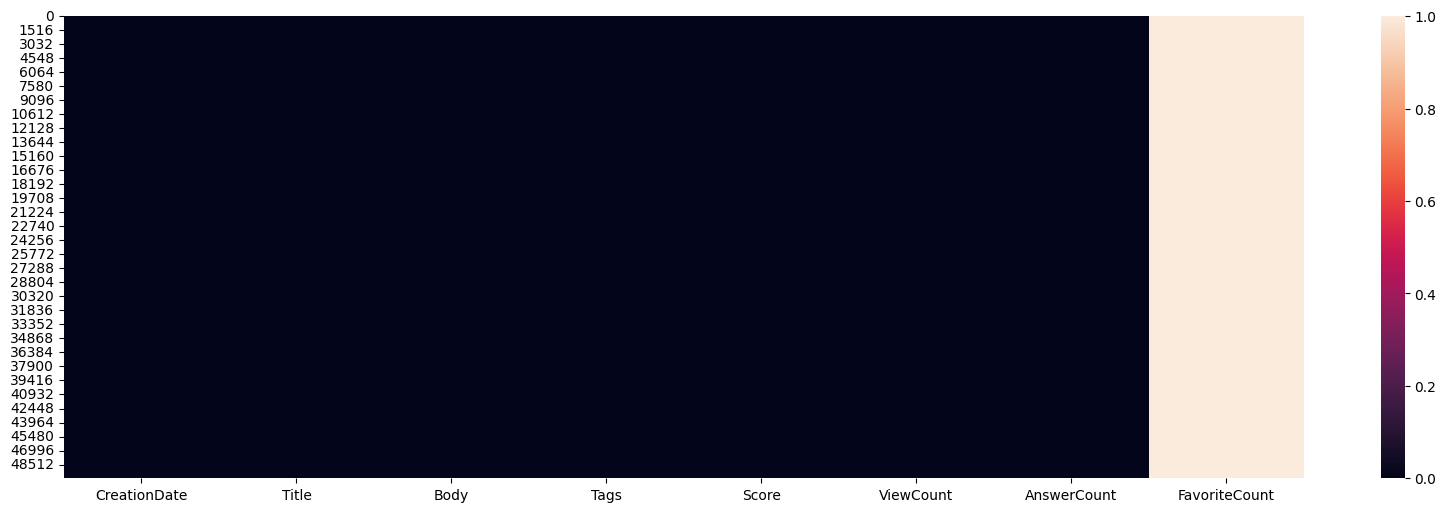

In [20]:
# Visualisation des valeurs manquantes.
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.heatmap(df.isna())

In [21]:
# Suppression de la variable 'FavoriteCount' car elle ne contient aucune information.
df = df.drop(columns=['FavoriteCount'])

On constate des valeurs manquantes pour la variable FavoriteCount, pour le moment ce n'est pas bloquant car les variables qui m'interessent sont plutôt celles contenant des données texte ("Title","Body","Tags").

In [23]:
# Nombre de doublons pour une ligne entière de données.
df.duplicated().sum()

0

In [24]:
# Nombre de valeurs uniques par colonnes.
df.nunique()

CreationDate    49990
Title           50000
Body            50000
Tags            48067
Score             350
ViewCount       24877
AnswerCount        54
dtype: int64

In [25]:
# Nombre de doublons par colonnes.
for col in df.columns:
    n = df.duplicated(subset=col).sum()
    print(f"{col} : {n}")

CreationDate : 10
Title : 0
Body : 0
Tags : 1933
Score : 49650
ViewCount : 25123
AnswerCount : 49946


In [26]:
# Selection des variables necessaires pour la suite de l'étude.
df = df[['CreationDate','Title', 'Body', 'Tags']]
df.head()

,CreationDate,Title,Body,Tags
0,2019-11-28 06:53:15,What is the best way to handle the background ...,<p>I am trying to train a <strong>UNET</strong...,<tensorflow><machine-learning><deep-learning><...
1,2019-11-28 06:53:52,How can I serve my django website from multipl...,"<p>I have my django website, which I want to m...",<django><server><distributed-computing><distri...
2,2017-08-15 00:51:30,Does HTML's 'onclick' work on mobile devices?,<p>Does the HTML onclick attribute work on iOS...,<javascript><html><ios><events><browser>
3,2017-08-15 01:13:39,How to center an image in React Native,<h5>Background</h5>\n<p>I have an image meant ...,<javascript><react-native><layout><react-nativ...
4,2017-08-15 01:24:52,Module not found: Can't resolve 'style',<p>I am trying to configure css modules using ...,<javascript><reactjs><webpack><sass><css-modules>


<a name="C4"><font color='chocolate'>**Respect du RGPD.**</font></a>

[source : cnil](https://www.cnil.fr/fr/cnil-direct/question/quels-sont-les-grands-principes-des-regles-de-protection-des-donnees)

Description et application des 5 grands principes du Règlement Général sur la Protection des Données (RGPD) dans ce projet

- <span style="text-decoration: underline;">Le principe de finalité</span> : *le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime.*
 
  =>  Les données collectées sont utilisée exclusivement dans le cadre de la création d'un algorithme de machine learning qui permet d'assigner automatiquement plusieurs tags pertinents à une question. Les données ne sont pas déstinées à quelconques autres usages.

- <span style="text-decoration: underline;">Le principe de proportionnalité et de pertinence</span> : *les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier.*
  
  => On utilise des filtres sur les données de la requête pour ne récupérer que les variables essentielles au projet. On évite également de récupérer des information non necessaire qui permettrait d'identifier un individu.

- <span style="text-decoration: underline;">Le principe d'une durée de conservation limitée</span> : *il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier.*

  => Les données ne contiennent pas d'information permettant l'identification de personnes, cependant, si c'était le cas il serait necessaire de fixer une date maximale de suppression des données en accord avec les contraintes légales ou d'anonymiser les données si elles doivent être conservées plus longtemps.

- <span style="text-decoration: underline;">Le principe de sécurité et de confidentialité</span> : *le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations.*

  => Içi on ne récupère pas de <font color = 'grey'>données à caractère personnel*</font>, si ça avait été le cas, il serait necessaire d'utiliser des données fictives ou d'anonymiser les données permettant d'identifier un individu.

- <span style="text-decoration: underline;">Les droits des personnes</span> : *Le propriétaire des données doit avoir donné son accord pour que ses données personnelles soient collectées et utilisées légalement.*

  => On s'assure que les utilisateurs aient accepté que leurs données personnelles soient collectées (par StackOverflow) grâce à l'onglet [Privacy Policy](https://stackoverflow.com/legal/privacy-policy). Içi on comprends que pour créer un compte utilisateurs, il faut accpéter les conditions de collecte des données par stackoverflow.

*<font color = 'grey'>*Toute information relative à une personne physique susceptible d'être identifiée, directement ou indirectement.</font>*

## <a name="C5"><font color='navy'>Nettoyage des données texte</a></font>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C6">Détection du langage.</a>
- <a href="#C7">Pré-traitement des données texte.</a>
- <a href="#C8">Création du vocabulaire.</a>

<a name="C6"><font color='chocolate'>**Détection du langage.**</font></a>

Dans un premier temps, comme on utilise des données sous forme de chaîne de caractères, je souhaite détecter le ou les langages utilisés dans la base de données. En fonction de la répartition des langages utilisés et si le langage le plus utilisé me permet d'avoir une volumétrie de donnée significative pour la suite de l'étude, je ne conserverais que les données du langage le plus utilisé par les internautes.

In [33]:
###################### A supprimer avant de tout relancer quand ok sur nettoyage jeu de données #####################
# Utilisation d'un échantillon pour tests plus rapides.
df = df.sample(frac=0.1)

In [34]:
# Application de la fonction pour détecter la langue utilisée.
message, language_counts, most_common_language, rate = detect_language_and_analyze(df, 'Body')

# Affichage du résultat.
print(message)

La langue la plus utilisée est 'en' (anglais) avec un taux d'utilisation de 99.22%.
Nombre de lignes en 'en': 14883 sur 15000 lignes totales.


On défini un seuil acceptable de représentation "top_langage" en fonction duquel on supprimera les lignes qui ne correspondent pas à "top_langage". Ce paramétrage du seuil est fixé dans le fichier data_preprocessing_config. Si la condition de respect de seuil n'est pas respectée, on ne supprime pas les lignes "autre langage".

In [36]:
# Fonction de supression des lignes "langages differents de langue majoritaire".
filtered_df = filter_top_language(df, seuil_representation_top_langage, rate, most_common_language)

Seuil défini pour le filtrage : 75.00%
Taux top langage suffisant pour créer un filtre afin de ne conserver que les top langages.


In [37]:
filtered_df.shape

(14883, 5)

In [38]:
# Suppression de la colonne "language".
filtered_df = filtered_df.drop(columns=['language'])
filtered_df.head()

,CreationDate,Title,Body,Tags
32560,2022-11-23 04:33:18,Why am I getting a ChromeProxyService error wi...,<p>I'm using <code>Flutter</code> version <cod...,<flutter><google-chrome><flutter-web><flutter-...
8183,2021-12-16 15:15:48,NextJs Next.config.mjs import local constant file,<h1>Importing local files in next.config</h1>\...,<javascript><reactjs><next.js><config><vercel>
16600,2020-06-02 10:53:30,How disable link (async module) prefetch / pre...,<p>How disable rel=&quot;prefetch&quot; in dyn...,<javascript><webpack><vue-cli><prefetch><vue-c...
38236,2017-02-09 15:02:11,replace string if length is less than x,<p>I have a dataframe below. </p>\n\n<pre><cod...,<python><string><pandas><replace><conditional-...
34029,2018-06-05 12:11:42,Is grouping multiple @Service and @Repository ...,<p>Question is a bit rhetorical. I've had an a...,<java><spring><design-patterns><dependency-inj...


<a name="C7"><font color='chocolate'>**Pré-traitement des données texte.**</font></a>

Ensuite, nous allons supprimer les caractères spéciaux, corriger les contractions de mots, séparer les phrases en unités de mots (Tokenisation) puis éliminer que les mots qui n'apportent pas d'informations (stopwords).

Quelques définitions :

***La tokenisation** est le processus de division d'un texte en unités plus petites appelées "tokens". Ces unités peuvent être des mots, des phrases ou même des caractères individuels. En traitement du langage naturel (NLP), la tokenisation est une étape essentielle qui permet de préparer le texte brut pour une analyse ultérieure, telle que la modélisation statistique ou l'apprentissage automatique.*

***Les Stopwords** sont des mots courants dans une langue qui sont souvent filtrés avant ou après le traitement des données textuelles. Ils sont généralement considérés comme ayant peu de valeur ajoutée pour les tâches de traitement du langage naturel (NLP), car ils n'apportent pas beaucoup d'information significative par rapport au contenu du texte.*

Enfin, l'idée est de créer le vocabulaire : 
Quelques définitions :

***Le vocabulaire** : il s'agit de l'ensemble des tokens distincts présents dans l'ensemble du corpus.*

***La lemmatisation** permet de regrouper différentes formes d'un mot sous une seule forme canonique, ce qui facilite l'analyse et le traitement des données textuelles. L'idée est d'utiliser des règles linguistiques et des dictionnaires pour transformer les mots en leur forme canonique correcte, en tenant compte du contexte grammatical (par exemple, "better" devient "good" et "running" devient "run").*

***Le stemming** consiste à couper les suffixes des mots pour obtenir la racine (par exemple, "running" devient "run").*

***POS Tagging (Part-of-Speech Tagging)** : représente les méthodes qui récupèrent la nature grammatical des mots d’une phrase - nom, verbe, adjectif, etc. Ce sont des propriété qui peuvent servir de caractéristiques utile lors de la création de certains modèles.*

***NER (Named Entity Recognition)** : reconnaître des personnes, endroits, entreprises, etc.*

On utilisera içi la lemmatisation, cette méthode est plus facile à interpréter que stemming car on utilise la forme canonique des mots donc on ne les sort pas de leur contexte (tandis que stemming supprime les suffixe ce qui rend plus compliqué l'interprétation des mots en sortie).

**Variable Tags.**

In [42]:
# Application des fonctions de pré-traitement des tags.
filtered_df = filtered_df.copy()
filtered_df['tags_cleaned'] = filtered_df['Tags'].apply(lambda x: clean_tags(x))

In [43]:
filtered_df.head()

,CreationDate,Title,Body,Tags,tags_cleaned
32560,2022-11-23 04:33:18,Why am I getting a ChromeProxyService error wi...,<p>I'm using <code>Flutter</code> version <cod...,<flutter><google-chrome><flutter-web><flutter-...,"[flutter, google-chrome, flutter-web, flutter-..."
8183,2021-12-16 15:15:48,NextJs Next.config.mjs import local constant file,<h1>Importing local files in next.config</h1>\...,<javascript><reactjs><next.js><config><vercel>,"[javascript, reactjs, next.js, config, vercel]"
16600,2020-06-02 10:53:30,How disable link (async module) prefetch / pre...,<p>How disable rel=&quot;prefetch&quot; in dyn...,<javascript><webpack><vue-cli><prefetch><vue-c...,"[javascript, webpack, vue-cli, prefetch, vue-c..."
38236,2017-02-09 15:02:11,replace string if length is less than x,<p>I have a dataframe below. </p>\n\n<pre><cod...,<python><string><pandas><replace><conditional-...,"[python, string, pandas, replace, conditional-..."
34029,2018-06-05 12:11:42,Is grouping multiple @Service and @Repository ...,<p>Question is a bit rhetorical. I've had an a...,<java><spring><design-patterns><dependency-inj...,"[java, spring, design-patterns, dependency-inj..."


**Analyse des POS (part-of-speech) Tagging les plus fréquents dans les Tags.**

In [45]:
# Conversion des colonnes contenant des listes en texte.
columns_to_convert = ['tags_cleaned']
filtered_df = convert_lists_to_text(filtered_df, columns_to_convert)

In [46]:
# Application de la fonction de POS Tagging.
filtered_df['pos_tagging_tags'] = filtered_df['tags_cleaned'].apply(pos_tagging_fct)

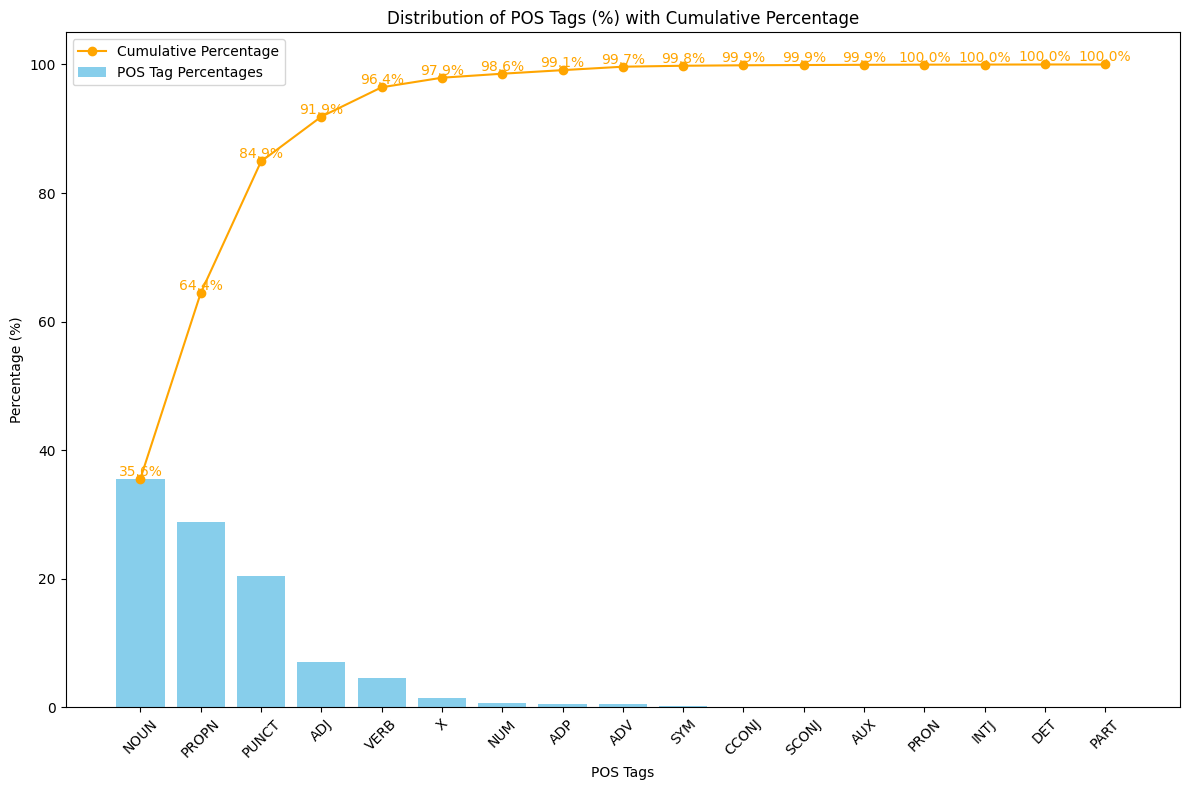

In [47]:
# Répartition des POS Tagging pour les tags.
# Extraction de toutes les étiquettes POS.
all_pos_tags = [pos for sublist in filtered_df['pos_tagging_tags'] for word, pos in sublist]

# Calcul de la fréquence des étiquettes POS.
pos_tag_counts = Counter(all_pos_tags)

# Tri par ordre décroissant de fréquence.
pos_tag_counts_sorted = dict(sorted(pos_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Calcul du total des étiquettes POS.
total_pos_tags = sum(pos_tag_counts_sorted.values())

# Calcul des pourcentages pour chaque POS.
pos_tag_percentages = {pos: (count / total_pos_tags) * 100 for pos, count in pos_tag_counts_sorted.items()}

# Conversion en deux listes pour le graphique : étiquettes POS et leurs pourcentages.
labels, percentages = zip(*pos_tag_percentages.items())

# Calcul du pourcentage cumulé.
cumulative_percentages = np.cumsum(percentages)

# Création du graphique en barres.
plt.figure(figsize=(12, 8))

# Trace les barres.
plt.bar(labels, percentages, color='skyblue', label='POS Tag Percentages')

# Trace la courbe de pourcentage cumulé.
plt.plot(labels, cumulative_percentages, color='orange', marker='o', linestyle='-', label='Cumulative Percentage')

# Ajout des pourcentages cumulés au-dessus de chaque point sur la courbe.
for i, txt in enumerate(cumulative_percentages):
    plt.text(labels[i], cumulative_percentages[i], f'{txt:.1f}%', 
             color='orange', ha='center', va='bottom', fontsize=10)

# Ajout des légendes et titres.
plt.xlabel('POS Tags')
plt.ylabel('Percentage (%)')
plt.title('Distribution of POS Tags (%) with Cumulative Percentage')
plt.xticks(rotation=45)

# Affichage de la légende.
plt.legend()

# Affichage du graphique.
plt.tight_layout()
plt.show()

Avec les 5 POS Tagging les plus fréquents on garde 96% des tags. On va tenter cette approche pour réduite la dimension des données.

In [49]:
# Sélection des TOP 5 POS tags les plus fréquents.
top_4_pos_tags = list(pos_tag_counts_sorted.keys())[:4]

print("TOP 4 POS tags:", top_4_pos_tags)

TOP 4 POS tags: ['NOUN', 'PROPN', 'PUNCT', 'ADJ']


In [50]:
# Calcul des fréquences de mots dans 'tags_cleaned'
word_frequencies_tags = get_word_frequencies(filtered_df['tags_cleaned'])

# Affichage des 20 mots les plus fréquents
print(word_frequencies_tags.most_common(20))

[('python', 2363), ('javascript', 2004), ('java', 1491), ('android', 1329), ('c', 939), ('c++', 918), ('ios', 885), ('reactjs', 847), ('node.js', 776), ('#', 676), ('swift', 599), ('typescript', 561), ('python-3.x', 555), ('angular', 537), ('html', 528), ('php', 454), ('spring', 450), ('css', 438), ('spring-boot', 423), ('pandas', 356)]


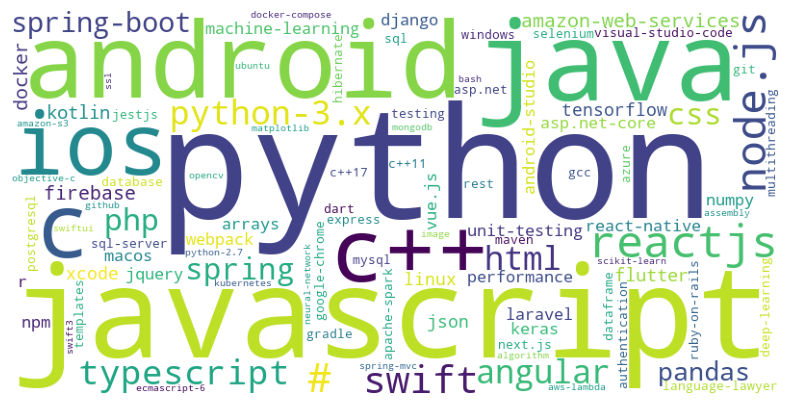

In [51]:
# Visualisation des mots de la variable tags_cleaned dans un wordCloud.
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white',
                      max_words=100).generate_from_frequencies(dict(word_frequencies_tags))

# Affichage du WordCloud.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Variables Title et Body.**

In [53]:
# Suppression des balises html en début et fin de chaque lignes pour la variable "body".
filtered_df['body_cleaned'] = filtered_df['Body'].apply(lambda x: remove_html_tags_edges(x))
filtered_df.head()

,CreationDate,Title,Body,Tags,tags_cleaned,pos_tagging_tags,body_cleaned
32560,2022-11-23 04:33:18,Why am I getting a ChromeProxyService error wi...,<p>I'm using <code>Flutter</code> version <cod...,<flutter><google-chrome><flutter-web><flutter-...,flutter google-chrome flutter-web flutter-http...,"[(flutter, NOUN), (google, PROPN), (-, PUNCT),...",I'm using <code>Flutter</code> version <code>3...
8183,2021-12-16 15:15:48,NextJs Next.config.mjs import local constant file,<h1>Importing local files in next.config</h1>\...,<javascript><reactjs><next.js><config><vercel>,javascript reactjs next.js config vercel,"[(javascript, PROPN), (reactjs, PROPN), (next....",Importing local files in next.config</h1>\n<h2...
16600,2020-06-02 10:53:30,How disable link (async module) prefetch / pre...,<p>How disable rel=&quot;prefetch&quot; in dyn...,<javascript><webpack><vue-cli><prefetch><vue-c...,javascript webpack vue-cli prefetch vue-cli-4,"[(javascript, PROPN), (webpack, VERB), (vue, P...",How disable rel=&quot;prefetch&quot; in dynami...
38236,2017-02-09 15:02:11,replace string if length is less than x,<p>I have a dataframe below. </p>\n\n<pre><cod...,<python><string><pandas><replace><conditional-...,python string pandas replace conditional-state...,"[(python, NOUN), (string, NOUN), (pandas, NOUN...",I have a dataframe below. </p>\n\n<pre><code>a...
34029,2018-06-05 12:11:42,Is grouping multiple @Service and @Repository ...,<p>Question is a bit rhetorical. I've had an a...,<java><spring><design-patterns><dependency-inj...,java spring design-patterns dependency-injecti...,"[(java, PROPN), (spring, PROPN), (design, NOUN...",Question is a bit rhetorical. I've had an argu...


Dans un premier temps nous allons regrouper les colonnes Title et Body pour les traiter ensemble et appliquer les mêmes étapes de nettoyage.

In [55]:
# Regroupement des colonnes 'Title' (pondération x2) et 'Body' en une nouvelle colonne 'Text'.
filtered_df = filtered_df.copy()
filtered_df['text'] = filtered_df['Title'] + ' ' + filtered_df['body_cleaned']

In [56]:
# Conversion des colonnes contenant des listes en texte.
columns_to_convert = ['text']
corpus_text_init = convert_lists_to_text(filtered_df, columns_to_convert)
corpus_text_init.head()

,CreationDate,Title,Body,Tags,tags_cleaned,pos_tagging_tags,body_cleaned,text
32560,2022-11-23 04:33:18,Why am I getting a ChromeProxyService error wi...,<p>I'm using <code>Flutter</code> version <cod...,<flutter><google-chrome><flutter-web><flutter-...,flutter google-chrome flutter-web flutter-http...,"[(flutter, NOUN), (google, PROPN), (-, PUNCT),...",I'm using <code>Flutter</code> version <code>3...,Why am I getting a ChromeProxyService error wi...
8183,2021-12-16 15:15:48,NextJs Next.config.mjs import local constant file,<h1>Importing local files in next.config</h1>\...,<javascript><reactjs><next.js><config><vercel>,javascript reactjs next.js config vercel,"[(javascript, PROPN), (reactjs, PROPN), (next....",Importing local files in next.config</h1>\n<h2...,NextJs Next.config.mjs import local constant f...
16600,2020-06-02 10:53:30,How disable link (async module) prefetch / pre...,<p>How disable rel=&quot;prefetch&quot; in dyn...,<javascript><webpack><vue-cli><prefetch><vue-c...,javascript webpack vue-cli prefetch vue-cli-4,"[(javascript, PROPN), (webpack, VERB), (vue, P...",How disable rel=&quot;prefetch&quot; in dynami...,How disable link (async module) prefetch / pre...
38236,2017-02-09 15:02:11,replace string if length is less than x,<p>I have a dataframe below. </p>\n\n<pre><cod...,<python><string><pandas><replace><conditional-...,python string pandas replace conditional-state...,"[(python, NOUN), (string, NOUN), (pandas, NOUN...",I have a dataframe below. </p>\n\n<pre><code>a...,replace string if length is less than x I have...
34029,2018-06-05 12:11:42,Is grouping multiple @Service and @Repository ...,<p>Question is a bit rhetorical. I've had an a...,<java><spring><design-patterns><dependency-inj...,java spring design-patterns dependency-injecti...,"[(java, PROPN), (spring, PROPN), (design, NOUN...",Question is a bit rhetorical. I've had an argu...,Is grouping multiple @Service and @Repository ...


In [57]:
# Calcul des fréquences de mots dans 'text'.
word_frequencies_text = get_word_frequencies(filtered_df['text'])

# Conversion des fréquences en DataFrame pour l'analyse
word_frequencies_df = pd.DataFrame(word_frequencies_text.values(), columns=['frequency'])

# Résumé statistique avec describe()
frequency_stats = word_frequencies_df['frequency'].describe()
frequency_stats

count    302855.000000
mean         22.406561
std        1524.846286
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max      422077.000000
Name: frequency, dtype: float64

On note que la moitié des tokens du jeu de données est unique. Supprimer les tokens unique permettrait de réduire conidérablement la dimension des données.

**Traitement des mots rare.**

In [60]:
# Affichage des mots uniques, max_5 fois, max_10 fois, et max_20 fois.
list_unique_words = [word for word, freq in word_frequencies_text.items() if freq == 1]
list_2_5_words = [word for word, freq in word_frequencies_text.items() if 1 < freq <= 5]
list_6_10_words = [word for word, freq in word_frequencies_text.items() if 5 < freq <= 10]
list_11_20_words = [word for word, freq in word_frequencies_text.items() if 10 < freq <= 20]

# Affichage des résultats
print(f"Nombre de mots uniques : {len(list_unique_words)}")
print(f"Nombre de mots présents entre 2 et 5 fois : {len(list_2_5_words)}")
print(f"Nombre de mots présents entre 6 et 10 fois : {len(list_6_10_words)}")
print(f"Nombre de mots présents entre 11 et 20 fois : {len(list_11_20_words)}")

Nombre de mots uniques : 176527
Nombre de mots présents entre 2 et 5 fois : 94775
Nombre de mots présents entre 6 et 10 fois : 14110
Nombre de mots présents entre 11 et 20 fois : 7469


In [61]:
random_list_unique_words = random.sample(list_unique_words, 20)
print(random_list_unique_words)

['sqFrom', 'grouby', 'OD_VALUES_ID_GEN', 'NSRectEdge.minY', 'flow.register', '17613', 'com.appointment.schedular.tenant', 'arr.loc', 'r.callback', 'apps/webshop/src/app/app.component.html:3:3', "'application/soap+xml", '-420', 'newMember', '//stackoverflow.com/a/71680636/17880487', 'attachment-service', 'R.id.nav_contact_us', 'boost/boost_1_67_0', 'auth.0009_alter_user_last_name_max_length', 'modalRef', 'customerRepository.findBySessionId']


In [62]:
random_list_2_5_words = random.sample(list_2_5_words, 20)
print(random_list_2_5_words)

['impressive', 'firebase-crashlytics-gradle', 'node.id', 'asset.pixelWidth', 'azure_file', 'factorA', 'medical', 'Horizontally', 'Main-Class', '30326', 'MdDialog', '//github.com/zloirock/core-js', 'JSONToCSV', 'evidenced', 'oauth_client_details', './node_modules/sass-loader/lib/loader.js', 'createCircle1', 'Oil', '_auth', 'kotlin-stdlib-jdk7:1.6.10']


In [63]:
random_list_6_10_words = random.sample(list_6_10_words, 20)
print(random_list_6_10_words)

['HandlerWidget.VERTICAL', 'HttpConnection', 'Adds', 'this.form.get', 'userinfo', 'IsActive', 'UUID.randomUUID', 'mAudioOutStream.next_pts', 'BookRepository', 'model.save', 'combineLatest', '/BODY', 'fileobj', 'bt', 'file.pdf', 'Redundancy', 'nginx.conf', 'v7', '//Update', 'Vectorization']


In [64]:
random_list_11_20_words = random.sample(list_11_20_words, 20)
print(random_list_11_20_words)

['AVFoundation', 'product_type', 'Certification', 'prefetched', 'selectors', 'eigenvalues', 'Hat', 'springdoc-openapi-ui', 'E2E', 'Launching', "'top", 'paging', 'spring-web-4.3.12.RELEASE.jar:4.3.12.RELEASE', 'vec_dimension', 'LaTeX', 'PageTabViewStyle', 'chrome_options.add_argument', 'ViCo92', 'Excluding', '__len__']


In [65]:
# Choix.
list_max_20_words = [word for word, freq in word_frequencies_text.items() if freq <= 20]
print(f"Nombre de mots présents maximum 20 fois : {len(list_max_20_words)}")

Nombre de mots présents maximum 20 fois : 292881


On utilisera differentes techniques pour le nettoyage des données texte en fonction de la manière dont les textes seront utilisés dans le modèle. 

**BoW et TF-IDF** : Ces méthodes sont basées sur des représentations discrètes de mots (comptes de mots), donc le nettoyage du texte (suppression des stop words, lemmatisation) est crucial pour réduire le bruit et concentrer l'information sur les mots les plus significatifs.

**Word2Vec** : Similaire à BoW et TF-IDF, mais il génère des embeddings vectoriels pour les mots. Cependant, conserver la forme originale des mots peut parfois être avantageux pour capturer des nuances sémantiques spécifiques.

**Modèles Deep Learning (USE, BERT)** : Ces modèles sont conçus pour comprendre le contexte et les relations sémantiques dans les phrases. Ils peuvent bénéficier d'un texte moins transformé, car les stop words et les formes originales des mots peuvent porter des informations contextuelles cruciales.

In [ ]:
# Application des fonctions de transformation aux données.
filtered_df['sentence_bow_lem'] = filtered_df['text'].apply(lambda x: transform_bow_lem_fct(x, list_max_20_words))

In [ ]:
filtered_df['sentence_bow'] = filtered_df['text'].apply(lambda x: transform_bow_fct(x))

In [ ]:
filtered_df['sentence_dl'] = filtered_df['text'].apply(lambda x: transform_dl_fct(x))

In [ ]:
# Affichage du DataFrame.
filtered_df.head()

In [ ]:
# Séléction des colonnes necessaires au projet.
filtered_df_util = filtered_df[['text', 'tags_cleaned', 'sentence_bow_lem', 'sentence_bow', 'sentence_dl']]
filtered_df_util.head()

In [ ]:
# Enregistrement des données nettoyées dans le fichier.
# filtered_df_util.to_json('filtered_df_util.json', orient='records', lines=True)

In [ ]:
# Visualisation de la ligne 1.
pd.set_option('display.max_colwidth', None)
print(filtered_df_util.iloc[0])

In [ ]:
# Compte les mots pour la variable 'text'.
total_text, distinct_text = count_words(filtered_df_util['text'])

# Compte les mots pour la variable 'sentence_bow_lem'.
total_bow_lem, distinct_bow_lem = count_words(filtered_df_util['sentence_bow_lem'])

# Affichage des résultats.
print(f"Nombre total de mots dans 'text' : {total_text}")
print(f"Nombre de mots distincts dans 'text' : {distinct_text}")
print(f"Nombre total de mots dans 'sentence_bow_lem' : {total_bow_lem}")
print(f"Nombre de mots distincts dans 'sentence_bow_lem' : {distinct_bow_lem}")

# Comparaison des résultats.
print(f"Différence (total de mots) : {total_bow_lem - total_text}")
print(f"Différence (mots distincts) : {distinct_bow_lem - distinct_text}")

**Selection des mots dont l'étiquette de POS tagging correspont aux 4 POS Tagging les plus présents dans cleaned_tags.**

In [ ]:
# Application de la fonction de POS Tagging pour la variable 'sentence_bow_lem'.
filtered_df_util = filtered_df_util.copy()
filtered_df_util.loc[:, 'pos_tagging_sentence_bow_lem'] = filtered_df_util['sentence_bow_lem'].apply(pos_tagging_fct)

In [ ]:
# Répartition des POS Tagging pour 'sentence_bow_lem'.
# Extraction de toutes les étiquettes POS.
all_pos_tags = [pos for sublist in filtered_df_util['pos_tagging_sentence_bow_lem'] for word, pos in sublist]

# Calcul de la fréquence des étiquettes POS.
pos_tag_counts = Counter(all_pos_tags)

# Tri par ordre décroissant de fréquence.
pos_tag_counts_sorted = dict(sorted(pos_tag_counts.items(), key=lambda item: item[1], reverse=True))

# Calcul du total des étiquettes POS.
total_pos_tags = sum(pos_tag_counts_sorted.values())

# Calcul des pourcentages pour chaque POS.
pos_tag_percentages = {pos: (count / total_pos_tags) * 100 for pos, count in pos_tag_counts_sorted.items()}

# Conversion en deux listes pour le graphique : étiquettes POS et leurs pourcentages.
labels, percentages = zip(*pos_tag_percentages.items())

# Calcul du pourcentage cumulé.
cumulative_percentages = np.cumsum(percentages)

# Création du graphique en barres.
plt.figure(figsize=(12, 8))

# Trace les barres.
plt.bar(labels, percentages, color='skyblue', label='POS Percentages')

# Trace la courbe de pourcentage cumulé.
plt.plot(labels, cumulative_percentages, color='orange', marker='o', linestyle='-', label='Cumulative Percentage')

# Ajout des pourcentages cumulés au-dessus de chaque point sur la courbe.
for i, txt in enumerate(cumulative_percentages):
    plt.text(labels[i], cumulative_percentages[i], f'{txt:.1f}%', 
             color='orange', ha='center', va='bottom', fontsize=10)

# Ajout des légendes et titres.
plt.xlabel('POS Tagging sentence_bow_lem')
plt.ylabel('Percentage (%)')
plt.title('Distribution of POS (%) with Cumulative Percentage')
plt.xticks(rotation=45)

# Affichage de la légende.
plt.legend()

# Affichage du graphique.
plt.tight_layout()
plt.show()

In [ ]:
# Séléction des étiquettes POS tagging les plus présentes dans les tags.
filtered_df_util = filtered_df_util.copy()
filtered_df_util.loc[:, 'sentence_bow_lem_pos'] = filtered_df_util['sentence_bow_lem'].apply(filter_by_pos_tags)

In [ ]:
# Compte les mots pour la variable 'sentence_bow_lem'.
total_bow_lem, distinct_bow_lem = count_words(filtered_df_util['sentence_bow_lem'])

# Compte les mots pour la variable 'sentence_bow_lem_pos'.
total_bow_lem_pos, distinct_bow_lem_pos = count_words(filtered_df_util['sentence_bow_lem_pos'])

# Affichage des résultats
print(f"Nombre total de mots dans 'sentence_bow_lem' : {total_bow_lem}")
print(f"Nombre de mots distincts dans 'sentence_bow_lem' : {distinct_bow_lem}")
print(f"Nombre total de mots dans 'sentence_bow_lem_pos' : {total_bow_lem_pos}")
print(f"Nombre de mots distincts dans 'sentence_bow_lem_pos' : {distinct_bow_lem_pos}")

# Comparaison des résultats
print(f"Différence (total de mots) : {total_bow_lem_pos - total_bow_lem}")
print(f"Différence (mots distincts) : {distinct_bow_lem_pos - distinct_bow_lem}")

In [ ]:
# Calcul des fréquences de mots dans 'sentence_bow_lem_pos'
word_frequencies_sentence_bow_lem_pos = get_word_frequencies(filtered_df_util['sentence_bow_lem_pos'])

# Affichage des 10 mots les plus fréquents
print(word_frequencies_sentence_bow_lem_pos.most_common(20))

In [ ]:
# Visualisation des mots de la variable sentence_bow_lem_pos dans un wordCloud.
wordcloud = WordCloud(width=800, 
                      height=400, 
                      background_color='white',
                      max_words=100).generate_from_frequencies(dict(word_frequencies_sentence_bow_lem_pos))

# Affichage du WordCloud.
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# Vérification de la complétude des données.
filtered_df_util.isna().mean()

In [ ]:
# Enregistrement des colonnes necessaires.
filtered_df_selected_columns = filtered_df_util[['text', 'tags_cleaned', 'sentence_bow_lem_pos', 'sentence_bow', 'sentence_dl']]

In [ ]:
# Enregistrement des données nettoyées dans le fichier.
filtered_df_util.to_json('cleaned_df_final.json', orient='records', lines=True)

## <a name="C10"><font color='navy'>Vectorisation du texte</a></font>

<font color='navy'>**Dans cette partie, je réalise les étapes suivantes :**</font>
- <a href="#C11">BoW et TF-IDF.</a>
- <a href="#C12">Word2Vec.</a>
- <a href="#C13">USE et BERT.</a>

*En traitement du langage naturel (NLP), transformer du texte en un format que les ordinateurs peuvent comprendre est crucial. Les ordinateurs travaillent avec des nombres, donc l'une des étapes essentielles du préprocessing de texte consiste à convertir les mots ou phrases en vecteurs numériques.*

**Les méthodes d’extraction de features qui seront utilisées dans ce notebook :**</font>


<font color =blue>**1. BoW (Bag of Words) : Compte la fréquence des mots dans un texte sans tenir compte de l'ordre des mots.**

- <span style="text-decoration: underline;">Principe :</span>

Le modèle Bag of Words est une méthode simple qui consiste à représenter un texte en fonction de la présence ou de la fréquence des mots. C'est comme faire l'inventaire de tous les mots d'un texte.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

BoW commence par créer un "vocabulaire", qui est une liste de tous les mots uniques dans l'ensemble du document.
Pour chaque phrase ou document, tu comptes combien de fois chaque mot de ton vocabulaire apparaît.
Le résultat du BoW donne une matrice de fréquence, où chaque ligne représente une question et chaque colonne représente un mot du vocabulaire. Les cellules contiennent le nombre d'occurrences du mot dans le document.

- <span style="text-decoration: underline;">Limitation :</span>

BoW ne tient pas compte de l'ordre des mots. Par exemple, les phrases "le chat mange une souris" et "une souris mange le chat" auront la même représentation, même si leur sens est différent.
Le vocabulaire peut devenir très grand, surtout avec des documents longs ou nombreux.



<font color =blue>**2. TF-IDF (Term Frequency-Inverse Document Frequency) : Pèse les mots en fonction de leur fréquence, en tenant compte de leur importance dans le corpus.**</font>

- <span style="text-decoration: underline;">Principe :</span>

TF-IDF est une méthode qui mesure non seulement la fréquence d'un mot dans un document (comme BoW), mais aussi son importance par rapport à l'ensemble des documents dans le corpus. Elle atténue l'impact des mots très courants comme "le", "et", etc., qui n'apportent pas beaucoup de sens.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

TF (Term Frequency) : C'est simplement le nombre de fois qu'un mot apparaît dans un document divisé par le nombre total de mots dans ce document.
IDF (Inverse Document Frequency) : C'est une mesure de la rareté d'un mot dans l'ensemble du corpus. Plus un mot est rare (apparaît dans peu de documents), plus sa valeur IDF est élevée.
TF-IDF est le produit des deux : TF-IDF = TF * IDF.

- <span style="text-decoration: underline;">Limitation :</span>

Comme BoW, TF-IDF ne prend pas en compte l'ordre des mots et ne capture pas le sens ou le contexte.



<font color =blue>**3. Word2Vec : Capture les relations sémantiques entre les mots en les représentant par des vecteurs denses.**</font>

- <span style="text-decoration: underline;">Principe :</span>

Word2Vec est une technique qui transforme les mots en vecteurs de manière à capturer les relations sémantiques entre eux. Autrement dit, elle essaie de placer les mots avec des significations similaires dans des espaces proches les uns des autres.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

Word2Vec repose sur deux architectures principales : CBOW (Continuous Bag of Words) et Skip-gram. CBOW prédit un mot à partir de son contexte (les mots autour).
Skip-gram prédit le contexte à partir d'un mot. En entraînant un modèle sur de grandes quantités de texte, chaque mot est représenté par un vecteur dense, où les mots similaires (comme "roi" et "reine") sont proches dans l'espace vectoriel.

- <span style="text-decoration: underline;">Avantage :</span>

Contrairement à BoW et TF-IDF, Word2Vec capture les relations sémantiques et contextuelles entre les mots.

- <span style="text-decoration: underline;">Limitation :</span>

Word2Vec traite les mots individuellement et n'est pas conçu pour capturer le contexte d'une phrase entière.



<font color =blue>**4. Universal Sentence Encoder (USE) : Encode des phrases entières en vecteurs pour capturer le sens global de la phrase.**</font>

- <span style="text-decoration: underline;">Principe :</span>

Le Universal Sentence Encoder est une méthode qui encode des phrases entières (plutôt que des mots individuels) en vecteurs. Ces vecteurs capturent le sens global de la phrase.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

USE est basé sur des modèles profonds (deep learning) qui sont pré-entraînés sur de grandes quantités de texte. Le modèle prend une phrase en entrée et produit un vecteur numérique de dimension fixe.
Ce vecteur peut ensuite être utilisé pour des tâches comme la similarité entre phrases, le regroupement de textes, ou même l'analyse de sentiment.

- <span style="text-decoration: underline;">Avantage :</span>

USE capture le contexte de toute une phrase, ce qui le rend plus adapté aux tâches où le sens global est important.

- <span style="text-decoration: underline;">Limitation :</span>

Bien que très efficace pour capturer le sens global, il peut parfois perdre des informations très spécifiques contenues dans des mots individuels.



<font color =blue>**5. BERT (Bidirectional Encoder Representations from Transformers) : Comprend le contexte bidirectionnel des mots dans une phrase, capturant ainsi les significations les plus nuancées.**</font>

- <span style="text-decoration: underline;">Principe :</span>

BERT est un modèle extrêmement puissant qui comprend le contexte de chaque mot dans une phrase en tenant compte des mots qui le précèdent et le suivent. C'est ce qu'on appelle un modèle bidirectionnel.

- <span style="text-decoration: underline;">Comment ça fonctionne :</span>

BERT utilise une architecture appelée Transformers qui analyse le texte de manière bidirectionnelle. Il prend en compte les mots avant et après pour comprendre le contexte d'un mot particulier.
BERT peut être fine-tuné (ajusté) pour des tâches spécifiques comme la classification de texte, la réponse à des questions, etc.

- <span style="text-decoration: underline;">Avantage :</span>

Contrairement à Word2Vec ou même USE, BERT capture le contexte de manière bidirectionnelle, ce qui le rend particulièrement performant pour comprendre le sens nuancé des mots dans différents contextes.

- <span style="text-decoration: underline;">Limitation :</span>

BERT est très complexe et nécessite beaucoup de ressources informatiques pour l'entraînement et l'inférence. Il peut également être trop puissant pour des tâches simples où des techniques comme TF-IDF suffisent.

<a name="C11"><font color='chocolate'>**BoW et TF-IDF.**</font></a>

Le Bag of Words transforme les phrases en une matrice où chaque colonne représente un mot unique (vocabulaire), et chaque cellule contient la fréquence de ce mot dans chaque document.

In [79]:
# Import des données.
df = pd.read_json('cleaned_df_final.json', orient='records', lines=True)
df.head()

,text,tags_cleaned,sentence_bow_lem_pos,sentence_bow,sentence_dl
0,How to unit test a meteor method with practica...,testing meteor javascript unit-testing mocha.js,unit test method practicalmeteormocha unit man...,unit test meteor method practicalmeteormocha n...,how to unit test a meteor method with practica...
1,How to Update a flutter app on already publish...,flutter cross-platform java android dart,flutter app native android java app console na...,update flutter app already published native an...,how to update a flutter app on already publish...
2,TypeError: Cannot read properties of undefined...,nrwl-nx jest-preset-angular angular jestjs ts-...,typeerror property undefined ngmodule runing t...,typeerror read properties undefined reading ng...,typeerror can not read properties of undefined...
3,"Error: Attempted to call method ""format"" on nu...",date-formatting java spring-boot thymeleaf spring,error call method format null context object s...,error attempted call method format null contex...,error attempted to call method format on null ...
4,"What does ""Box<Fn() + Send + 'static>"" mean in...",types traits lifetime-scoping rust lifetime,box mean boxltfn staticgt rusti syntax reading...,box mean rust boxltfn send staticgt mean rusti...,what does box mean in rust what does boxltfn s...


In [85]:
# Création du Bag of Words pour la colonne 'sentence_bow_lem_pos'.
bow_vectorizer = CountVectorizer(max_df = 0.90, max_features=1000, stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(df['sentence_bow_lem_pos'])

# Affichage de la forme de la matrice BoW.
print(f"Bag of Words shape: {bow_matrix.shape}")

Bag of Words shape: (2482, 1000)


In [87]:
# Enregistrement de la matrice BoW (en format sparse pour économiser de l'espace).
sparse_bow_matrix = sparse.csr_matrix(bow_matrix)

with open('bow_matrix_sparse.pkl', 'wb') as f:
    pickle.dump(sparse_bow_matrix, f)

# Enregistrement du vectorizer.
with open('bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(bow_vectorizer, f)

print("La matrice BoW et le vectorizer ont été enregistrés avec succès.")

La matrice BoW et le vectorizer ont été enregistrés avec succès.


Le TF-IDF (Term Frequency - Inverse Document Frequency) prend en compte non seulement la fréquence des mots, mais aussi leur importance relative dans tous les documents.

In [89]:
# TF-IDF pour la colonne 'sentence_bow_lem_pos'.
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['sentence_bow_lem_pos'])

# Affichage de la forme de la matrice TF-IDF
print(f"TF-IDF shape: {tfidf_matrix.shape}")

TF-IDF shape: (2482, 1000)


In [91]:
# Enregistrement de la matrice TF-IDF (en format sparse pour économiser de l'espace).
sparse_tfidf_matrix = sparse.csr_matrix(tfidf_matrix)

with open('tfidf_matrix_sparse.pkl', 'wb') as f:
    pickle.dump(sparse_tfidf_matrix, f)

# Enregistrement du vectorizer.
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("La matrice TF-IDF et le vectorizer ont été enregistrés avec succès.")

La matrice TF-IDF et le vectorizer ont été enregistrés avec succès.


**Sauvegarde des Tags.**

In [95]:
# Sauvegarde de la colonne 'tags_cleaned' dans un fichier pickle.
with open('tags_cleaned.pkl', 'wb') as f:
    pickle.dump(df['tags_cleaned'], f)

print("Les tags nettoyés ont été sauvegardés avec succès.")

Les tags nettoyés ont été sauvegardés avec succès.


In [97]:
# Chargement des tags nettoyés du fichier pickle.
with open('tags_cleaned.pkl', 'rb') as f:
    tags_cleaned = pickle.load(f)

print(f"Nombre de tags chargés : {len(tags_cleaned)}")

Nombre de tags chargés : 2482


In [ ]:
filtered_df_selected_columns['tags_cleaned'].to_pickle('text_column.pkl')

## <a name="C5"><font color='navy'>Exploration des données</a></font>

In [111]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

Je vais commencer par réduire les dimensions de mes données en réalisant une ACP.

In [121]:
# Utilisationd de l'ACP.
pca = PCA()
pca.fit(tfidf_matrix.toarray())

# Variance expliquée par chaque composante.
explained_variance = pca.explained_variance_ratio_

# Variance cumulée.
cumulative_variance = np.cumsum(explained_variance)

# Recherche du nombre de composantes qui explique 90% de la variance.
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Nombre de composantes principales expliquant 90% de la variance: {n_components_90}")

Nombre de composantes principales expliquant 90% de la variance: 561


In [123]:
# Réduction de la dimension du jeu de données.
pca = PCA(n_components=n_components_90)  # Réduction de la matrice TF-IDF.
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())  # Conversion de la matrice sparse en dense pour ACP.

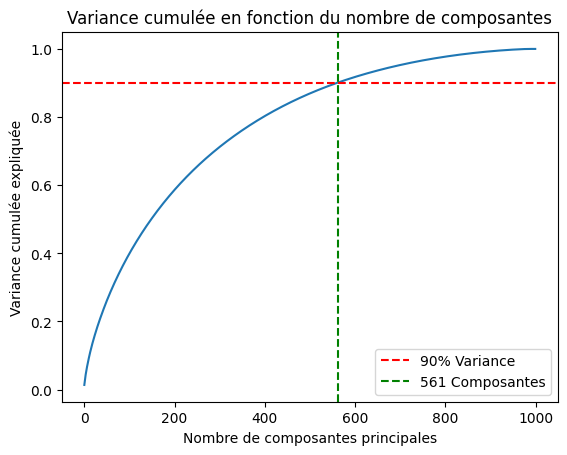

In [129]:
# Visualisation de la variance expliqué en fonction du nombre de composantes principales.
plt.plot(cumulative_variance)
plt.axhline(y=0.90, color='r', linestyle='--', label="90% Variance")
plt.axvline(x=n_components_90, color='g', linestyle='--', label=f"{n_components_90} Composantes")
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Variance cumulée expliquée")
plt.title("Variance cumulée en fonction du nombre de composantes")
plt.legend()
plt.show()

**Visualisation des résultats avec t-SNE**

In [125]:
# Application de t-SNE pour réduire la dimensionnalité à 2D.
tsne = TSNE(n_components=2, random_state=42)
tfidf_tsne = tsne.fit_transform(tfidf_matrix_reduced)

C:\Users\jouvi\AppData\Local\Temp\ipykernel_74976\3257943464.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=tfidf_tsne[:, 0], y=tfidf_tsne[:, 1], palette="viridis")


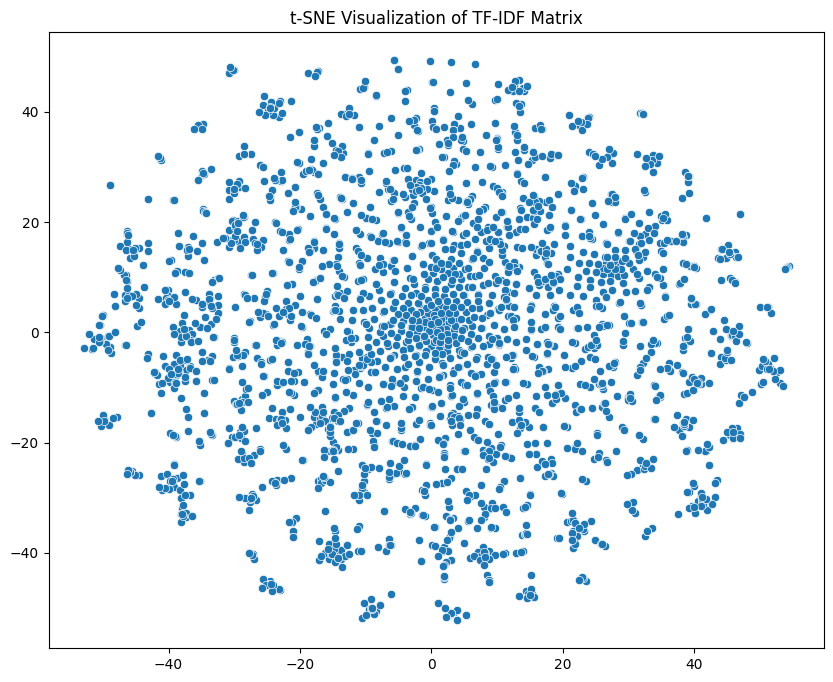

In [126]:
# Visualisation des résultats t-SNE.
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tfidf_tsne[:, 0], y=tfidf_tsne[:, 1], palette="viridis")
plt.title("t-SNE Visualization of TF-IDF Matrix")
plt.show()

Interprétation des résultats t-SNE :

- Chaque point dans le graphe représente un document (ou une question) transformé en un espace de 2 dimensions.<br>
- Les documents qui sont proches dans cet espace ont des distributions de termes similaires (avec la méthode d'extraction de features tf-idf), ce qui peut refléter des thèmes communs ou des similarités de contenu.<br>
- Si des clusters apparaissent visuellement, cela peut indiquer des groupes de documents traitant de sujets similaires.<br>
- Les zones vides ou les points isolés pourraient représenter des documents ayant un vocabulaire très spécifique ou unique par rapport aux autres.<br>